- To download this notebook, click the download icon in the toolbar above and select the .ipynb format.  
- For any questions or comments, please open an issue on the [c4dynamics issues page](https://github.com/C4dynamics/C4dynamics/issues).  


# Proportional Navigation Guidance - 6 Degrees of Freedom Simulation 

Six Degrees Of Freedom (6DOF) simulation of a guided aircraft, modeling its dynamics, aerodynamics, and control system.

## Contents

1. Introduction
2. Simulation Overview
3. Setup and Initial Conditions
4. Main Loop 
5. Miss Distance 
6. Results 
7. Summary 


## 1. Introduction 

This notebook presents a six degrees of freedom (6DOF) simulation of a guided aircraft, capturing the dynamics, aerodynamics, control system, and seeker behavior.
The guided aircraft in this case is a missile pursuing a target using a proportional navigation guidance law.
The simulation includes both translational and rotational dynamics, accounts for aerodynamic forces, and models control surface deflections in response to seeker feedback.

By walking through the setup, implementation, and results, the notebook provides a complete view of how 6DOF guidance algorithms operate in practice.
The missile, target, and seeker are modeled using the c4dynamics — an open-source framework for algorithm engineering that provides [state objects](https://c4dynamics.github.io/c4dynamics/api/States.html) to represent dynamic entities in space and time.
The details of the missile model and the guidance system are based on the example in Chapter 12 of the Military Handbook of Missile Flight Simulation [1].

## 2. Simulation Overview


<div style="text-align: center;">
  <img src="dof6sim.drawio.png" alt="alt text">
</div>

`Figure 1: Simulation Overview`  
The process begins with initial conditions, where the missile, target, and seeker (a line-of-sight sensor) are defined. Key parameters are set to establish the starting state.

The simulation then enters a main loop, which iterates at a time step of 5 milliseconds until termination conditions are met. 
Each iteration involves the following steps:

1. Update Atmospheric Properties: Atmospheric conditions, including pressure, density, and speed of sound, are calculated based on the missile’s current altitude using an atmospheric model. These properties determine aerodynamic forces and the Mach number, influencing the missile’s behavior.

2. Seeker Measurement: The line-of-sight seeker tracks angular rate variations between the missile and the target, providing critical data for trajectory adjustments. This step ensures the missile can track the target’s relative position and velocity.

4. Guidance & Control: After a 0.5-second delay to allow the missile to gain sufficient speed, the guidance system activates. It uses the seeker’s measurements to generate control commands, adjusting the missile’s pitch and yaw through control surface deflections to align its trajectory with the target.

5. Forces & Moments: Forces acting on the missile, including aerodynamic (lift, drag, axial, and normal), propulsion (thrust), and gravity, are computed. Aerodynamic moments (pitch and yaw) are also calculated based on the missile’s orientation and Mach number. These forces and moments are transformed into the inertial frame using the missile’s rotation matrix.

6. Integrate Equations of Motion: The missile’s translational and rotational equations of motion are integrated using a numerical method to update its position, velocity, Euler angles, and angular rates. The target’s position is similarly updated if it is moving, assuming no external forces for a non-maneuvering target.

7. Update Mass and Inertia Properties: As the missile consumes fuel, its mass and inertia properties are updated to reflect changes in dynamics.


After each iteration, the simulation evaluates termination conditions. If the range rate changes sign (indicating the closest approach), the missile’s altitude drops below zero, or the simulation time exceeds 100 seconds, the loop exits. Otherwise, it returns to updating atmospheric properties for the next iteration.

Upon termination, the simulation calculates the miss distance, determining the minimum distance between the missile and the target at the point of closest approach. This is approximated by analyzing the relative position vector perpendicular to the flight path and estimating the time of closest approach.

Finally, the results are shown: Trajectory Plots, Euler Angles, and Line-of-Sight Rates. These plots provide insights into the missile’s dynamic behavior and the guidance system’s performance. 


The program utilizes the following components of c4dynamics: 


| Object  | Module    | Description |
|---------|-----------|-------------|
| missile | [rigidbody](https://c4dynamics.github.io/c4dynamics/api/states.lib.rigidbody.html) | The missile is modeled as a rigid body, representing a mass in space with defined length and orientation |
| target  | [datapoint](https://c4dynamics.github.io/c4dynamics/api/states.lib.datapoint.html) | The target is represented as a datapoint object, modeling a point mass in space |
| seeker  | [sensors](https://c4dynamics.github.io/c4dynamics/api/Sensors.html)   | line-of-sight seeker 
| g_ms2   | [const](https://c4dynamics.github.io/c4dynamics/api/utils.const.html)     | Gravity constant in meters per second | 
| r2d     | [const](https://c4dynamics.github.io/c4dynamics/api/utils.const.html)     | Radians to degrees conversion constant |
| plotdefaults | [utils](https://c4dynamics.github.io/c4dynamics/api/generated/utils/c4dynamics.utils.plottools.plotdefaults.html) | Setting default properties on a matplotlib axis |


In addition, some operations use c4dynamics modules explicitly. Among them: 

`missile.RB` uses the rotmat module to rotate a vector from the body frame (B) to a reference frame (R). 

`missile.inteqm()` intgrates the equations of motion for a given vector of forces.  


Let's start.

## 3. Setup and Initial Conditions


### Import packages 

In [1]:
import c4dynamics as c4d 
import numpy as np

__  
Load the controller, engine, and aerodynamics models, developed specifically for this example.
These modules can be downloaded [here](https://raw.githubusercontent.com/C4dynamics/C4dynamics/refs/heads/main/docs/source/programs/dof6_modules.py).  
Download the file and place it in the same directory as this notebook or in any folder included in your Python path:

In [2]:
from dof6_modules import control_system, engine, aerodynamics

### Times setup

In [3]:
t  = 0
tf = 100
dt = 5e-3 

### Target

The target is a `datapoint` object which means it has all the attributes of a mass in space:  
`Position`: target.x, target.y, target.z.  
`Velocity`: target.vx, target.vy, target.vz.

It also has mass: target.mass (necessary for solving the equations of motion in the case of accelerating motion)

In this example, the target is initialized with specific positions along the three axes and a velocity component only along the x-axis.



In [4]:
target = c4d.datapoint(x = 4000, y = 1000, z = -3000, vx = -250)

### Missile

The missile is a `rigidbody` object, i.e. it has all the attributes of a datapoint, but also includes:  
`Body (Euler) angles`: missile.phi, missile.theta, missile.psi.   
`Angular rates`: missile.p, missile.q, missile.r (rotation about $x$, $y$, and $z$, respectively). 

As a rigidbody object, the missile possesses inertia attributes (necessary for solving the equations of accelerating motion):  
Moment of inertia: missile.ixx, missile.iyy, missile.izz.  


Since the rocket engine operates through fuel combustion, the missile's mass properties vary over time.

To enable mass recalculations during runtime, it is advisable to store the missile's initial conditions.

As $i_{yy}$ and $i_{zz}$ are equal here it's enough to save just one of them.
However, the initial position and initial attitude of any object (datapoint, rigidbody) are always saved on instantiation.   

The dimensions here are SI (i.e. seconds, meters, kilograms). 

In [5]:
m0      = 85        # initial mass, kg
mbo     = 57        # burnout mass, kg 
iyy0    = 61        # initial momoent of inertia about y and z 
ibo     = 47        # iyy izz at burnout 
xcm0    = 1.55      # initial distance from nose to center of mass, m 
xcmbo   = 1.35      # distance from nose to center of mass after burnout, m

In [6]:
missile = c4d.rigidbody()

In [7]:
missile.mass = m0              
missile.I = [0, iyy0, iyy0]
missile.xcm = xcm0  

### Modules

In [8]:
seeker = c4d.sensors.lineofsight(dt, tau1 = 0.01, tau2 = 0.01)
ctrl   = control_system(dt)
eng    = engine()
aero   = aerodynamics()

### Initial conditions 
The initial missile direction is calculated by employing a simple algorithm in which the missile is
pointed $30°$ below the line-of-sight to the target at the instant of launch.
The missile angular rates at launch are assumed to be negligible.

In [9]:
rTM           = target.Position - missile.Position
rTMnorm       = np.linalg.norm(rTM)
ucl           = rTM / rTMnorm # center line unit vector 

pitch_tgt   = np.arctan(ucl[2] / np.linalg.norm(ucl[:2])) * c4d.r2d
heading     = 30 # +30 tilts head down since z positive is downward.  
pitch_lnch  = pitch_tgt + heading
ucl[2]      = np.linalg.norm(ucl[:2]) * np.tan(pitch_lnch * c4d.d2r)
ucl         = ucl / np.linalg.norm(ucl)

missile.vx, missile.vy, missile.vz = 30 * ucl # 30m/s is the missile initial velocity
missile.psi   = np.arctan(ucl[1] / ucl[0])
missile.theta = np.arctan(-ucl[2] / np.sqrt(ucl[0]**2 + ucl[1]**2))
missile.phi   = 0
u, v, w       = missile.BR @ missile.Velocity
vc            = np.zeros(3)
ab_cmd        = np.zeros(3)
h             = -missile.z # missile altitude above sea level 

alpha       = 0
beta        = 0
alpha_total = 0
d_pitch     = 0
d_yaw       = 0

delta_data   = []
omegaf_data  = []
acc_data     = []
aoa_data     = []
moments_data = []

### Frame of coordinates and DCM

The property `missile.BR` returns a Body from Inertial DCM (Direction Cosine Matrix) in 3-2-1 order.
Using this matrix, the missile velocity vector in the inertial frame of coordinates is rotated to represent the velocity in the body frame of coordinates.

The inertial frame is determined by the frame that the initial Euler angles refer to.
In this example, the reference of the Euler angles are as follows:

- $\varphi$: rotation about $x$
- $\theta$: rotation about $y$
- $\psi$: rotation about $z$

The frame axes convention is given by: 

- $x$: parallel to flat earth in the direction of the missile centerline
- $y$: completes a right-hand system
- $z$: positive downward


## 4. Main loop
The main simulation loop performs the following steps:

Geometry 
- Update the target and the missile position and attitude according to the kinematics and initial conditions.
- Estimate the line-of-sight angular rate between the missile and target.
Guidance law
- Compute the proportional navigation command
- Generate wing deflection commands for the missile.
Kinematic equations 
- Calculate forces and moments acting on the missile.
- Integrate the missile's equations of motion.
- Integrate the target's equations of motion.

Here's a thorough explanation of each block:  

### Geometry

The target and missile positions are set by initial conditions or updated via kinematic differential equations. 

Then, the missile’s seeker measures the line-of-sight (LOS) vector, approximated as 
$r_{TM}$, and provides angular rates to the guidance system. 
The seeker resolves the LOS unit vector 
$u_R = r_{TM}/|r_{TM}|$ and computes the LOS angular rate as: 

$$ \omega = (r_{TM} × v_{TM}) / |r_{TM}|^2 $$

where:
- $r_{TM} = r_T - r_M$ is the relative position vector (target minus missile), 
- $v_{TM} = v_T - v_M$ is the relative velocity. 


The geometry is further characterized by the range 
$R = |r_{TM}|$ 
and the closing velocity 
$V_c = -u_R \cdot v_{TM}$, 
which determines the rate of approach. 

### Guidance Law

The guidance law employs proportional navigation (PN), 
which aligns the missile’s velocity vector with the LOS to the target for interception. 

PN uses the LOS angular rate to generate corrective acceleration commands. 
The core equation is: 

$$a_c = N \cdot V_m \cdot \omega \times u_R$$
 
where: 
- $a_c$ is the acceleration command (perpendicular to the missile’s velocity)
- $N$ is the navigation gain (typically $3–5$, here: $4$)
- $V_m$ is the missile’s speed
- $\omega$ is the LOS angular rate vector 
- $u_R$ is the unit vector along the LOS. 

The LOS angular rate is measured by the seeker and calculated 
as described in the Geometry section. 

PN aims to nullify the LOS rate $(\omega → 0)$ to ensure a collision course. The commanded acceleration is transformed into the missile’s body frame using the rotation matrix (derived from Euler angles) and implemented via control surface deflections (e.g., pitch and yaw fins). 

### Kinematic Differential Equations

The kinematic differential equations govern the missile’s motion in a six degrees of freedom (6DOF) simulation, 
capturing both translational and rotational dynamics. 
These equations describe how the missile’s position, velocity, and attitude evolve under forces (e.g., aerodynamic, propulsion, gravity) and moments. 

The target is treated as a point mass (with no attitude) and resolved in three degrees of freedom with no forces exerted. 


For translational motion, Newton’s second law is applied in the inertial frame: 
$$ \dot{v} = F/m $$
where:
- $v = [v_x, v_y, v_z]$ is the velocity vector
- $F$ is the total force vector
- $m$ is the missile’s mass. 

Position is updated via 
$$ \dot{r} = v $$
where: 
- $r = [x, y, z]$. 

For rotational motion, the attitude is represented by Euler angles $(\varphi, \theta, \psi)$ — roll, pitch, and yaw, respectively. 

The Euler angle derivatives relate the body angular rates $(p, q, r)$ to the attitude rates: 
$$ 
\dot{\varphi} = p + q \cdot sin\varphi \cdot  tan\theta + r \cdot cos\varphi \cdot tan\theta 
$$
$$ 
\dot{\theta} =  q \cdot cos\varphi - r \cdot sin\varphi 
$$
$$ 
\dot{\psi}   = (q \cdot sin\varphi + r \cdot cos\varphi) / cos\theta 
$$ 

These equations account for the missile’s orientation, updated numerically to reflect changes due to aerodynamic moments and control surface deflections. 

The moments follow Euler’s equations for a rigid body: 

$$ \dot{\omega} = I^{-1} \cdot M $$
where:
- $\omega = [p, q, r]$
- $I$ is the inertia tensor
- $M$ is the moment vector. 

This framework ensures accurate propagation of the missile’s dynamic state.

*Note*:  
The implementation of the kinematic differential equations is part of the `eqm` module of `c4dynamics` and is encapsulated in the lines:

`missile.inteqm()`  
`target.inteqm()`  

The target, as a datapoint, runs the `int3` method which integrates the translational equations as given.
The missile, as a rigidbody object, runs `int6` and integrates the translation and rotational equations as given by eqm6.
For a detailed explanation of the integration and differential equations, see the [introduction to the equations of motion solvers module](https://c4dynamics.github.io/c4dynamics/api/routines.eqm.html#). 






The simulation runs until one of the following conditions is satisfied:  
- The range rate changes sign  
- The missile hits the ground  
- The simulation time is over  


Comments are introduced inline.


In [10]:
while t <= tf and h >= 0 and vc[0] >= 0: 
    
    # relative position
    vTM = target.Velocity - missile.Velocity # missile-target relative velocity 
    rTM = target.Position - missile.Position # relative position 

    # relative velcoity
    rTMnorm = np.linalg.norm(rTM) # for next round 
    uR     = rTM / rTMnorm # unit range vector 
    vc     = -uR * vTM # closing velocity 

    # calculate the line-of-sight rates  
    wf = seeker.measure(rTM, vTM)  
    omegaf_data.append([wf[1], wf[2]]) 
    
    # atmospheric calculations    
    pressure, rho, vs = aerodynamics.alt2atmo(h)
        
    mach = missile.V() / vs # mach number 
    Q = 1 / 2 * rho * missile.V()**2 # dynamic pressure 

    
    # guidance and control 
    if t >= 0.5:
        '''        
        The guidance is initiated half a second after launch in 
        order to permit the missile to gain enough speed so that 
        it can be controlled. 
        Then the line-of-sight rate vector and the missile velocity 
        are used to base maneuver commands and the control system 
        responds by deflecting the control surfaces. 
        '''
        Gs       = 4 * missile.V()
        a_cmd     = Gs * np.cross(wf, ucl)
        ab_cmd   = missile.BR @ a_cmd 
        afp, afy = ctrl.update(ab_cmd, Q)
        d_pitch  = afp - alpha 
        d_yaw    = afy - beta  
    
    acc_data.append(ab_cmd)
    delta_data.append([d_pitch, d_yaw])

    
    ''' forces and moments '''

    # aerodynamic forces 
    cL, cD = aero.f_coef(mach, alpha_total) # get lift and drag coefficients based on Mach number and angle of attack
    L = Q * aero.s * cL     # compute lift force using dynamic pressure, reference area, and lift coefficient
    D = Q * aero.s * cD     # compute drag force using dynamic pressure, reference area, and drag coefficient


    # aero axial force 
    A = D * np.cos(alpha_total) - L * np.sin(alpha_total) 
    # aero normal force
    N = D * np.sin(alpha_total) + L * np.cos(alpha_total)  
    
    # convert aerodynamic forces to body frame coordinates
    fAb = np.array([ -A     # axial force in body X-direction (negative because drag acts against velocity)
                    , N * (-v / np.sqrt(v**2 + w**2))   # normal force component in body Y-direction
                    , N * (-w / np.sqrt(v**2 + w**2))]) # normal force component in body Z-direction
    fAe = missile.RB @ fAb  # rotate aerodynamic forces to inertial frame

    # aerodynamic moments 
    cM, cN = aero.m_coef(mach, alpha, beta, d_pitch, d_yaw 
                        , missile.xcm, Q, missile.V(), fAb[1], fAb[2]
                            , missile.q, missile.r)     # compute pitch and yaw moment coefficients
    
    mA = np.array([0                     # aerodynamic moment in roll
                , Q * cM * aero.s * aero.d         # aerodynamic moment in pitch
                , Q * cN * aero.s * aero.d])       # aerodynamic moment in yaw 

    moments_data.append(mA)     # store aerodynamic moment data for analysis

    # propulsion force
    thrust, thref = eng.update(t, pressure)     # gt thrust force based on engine model and atmospheric pressure
    fPb = np.array([thrust, 0, 0])              # thrust acts purely in body X-direction

    fPe = missile.RB @ fPb  # rotate propulsion forces to inertial frame

    # gravity force
    fGe = np.array([0, 0, missile.mass * c4d.g_ms2])    # gravity force acting in inertial Z-direction

    # total forces
    forces = np.array([fAe[0] + fPe[0] + fGe[0]         # sum of aerodynamic, propulsion, and gravity forces in X
                        , fAe[1] + fPe[1] + fGe[1]       #  in Y
                            , fAe[2] + fPe[2] + fGe[2]])  #  in Z    
    

    '''
    So far the three types of forces and moments, i.e. aerodynamic, propulsion, 
    and gravitation, have been calculated.

    The missile.inteqm() function and the target.inteqm() function perform 
    integration on the derivatives of the equations of motion. 
    The integration is performed by running fourth-order Runge-Kutta. 
    For a datapoint, the equations are composed of translational equations, 
    while for a rigidbody they also include the rotational equations. 

    Therefore, for a datapoint object like the target, 
    a force vector is necessary for the evaluation of the derivatives. 
    The force must be given in the inertial frame of reference. 
    As the target in this example is not maneuvering, the force vector is [0, 0, 0].

    For the missile, as a rigidbody, 
    both a force vector and a moment vector are required to evaluate the derivatives. 
    The force vector must be given in the inertial frame of reference. 
    Therefore, the propulsion, and the aerodynamic forces are rotated 
    to the inertial frame using the missile.RB rotation matrix. 
    The gravity forces are already given in the inertial frame and therefore remain intact. 

    '''
    # missile motion integration
    missile.inteqm(forces, mA, dt)

    # rotate the velocities vector from the reference inertial frame 
    # to the missile body frame.
    u, v, w = missile.BR @ np.array([missile.vx, missile.vy, missile.vz])
    
    # target dynmaics 
    target.inteqm(np.array([0, 0, 0]), dt)

    # update  
    t += dt
    missile.store(t)
    target.store(t)


    ''' update mass and inertial properties '''
    missile.mass -= thref * dt / eng.Isp        
    missile.xcm   = xcm0 - (xcm0 - xcmbo) * (m0 - missile.mass) / (m0 - mbo)
    izz = iyy = iyy0 - (iyy0 - ibo) * (m0 - missile.mass) / (m0 - mbo)

    missile.I = [0, iyy, izz]

    alpha = np.arctan2(w, u)
    beta  = np.arctan2(-v, u)
    
    uvm = missile.Velocity / missile.V()
    ucl = np.array([np.cos(missile.theta) * np.cos(missile.psi)
                    , np.cos(missile.theta) * np.sin(missile.psi)
                    , np.sin(-missile.theta)])
    alpha_total = np.arccos(uvm @ ucl)
    aoa_data.append([alpha, beta, alpha_total])
    
    h = -missile.z


## 5. Miss distance

The simulation is stopped when the the line-of-sight vector $rTM$ reaches a minimum (its rate changes sign). 
Therefore the last two samples of the simulation are the last negative range rate and first positive 
range rate (see figure below).  
Now the closest approach (miss distance) and its time can be evaluated. 

1. Closest range: 
The miss distance vector is approximated as the component of $rTM$ that is perpendicular to the relative flight path at
the last computation time. ($dot(rTM, uvTM) \cdot uvTM$ is the component of $rTM$ along $uvTM$, i.e. the component of the position along the velocity)

2. Time at closest range 
The time of the closest approach
is approximated by calculating the time it takes the target to
travel along the relative flight path from the point of closest
approach to the final target position and then subtracting
this calculated time from the time of the last computation.


In [11]:
vTM = target.Velocity - missile.Velocity # missile-target relative velocity 
uvTM = vTM / np.linalg.norm(vTM)

rTM = target.Position - missile.Position # relative position 

md = np.linalg.norm(rTM - np.dot(rTM, uvTM) * uvTM)
tfinal = t - np.dot(rTM, uvTM) / np.linalg.norm(vTM)

print('miss: %.5f, flight time: %.1f' % (md, tfinal))

miss: 0.00339, flight time: 7.8


![alt text](missdistance.png)

`Figure 2: Miss-distance`  
Miss-distance vector diagram (taken from [1]). 
The descriptions in the handbook for the symbols in the illustration are: 
- $𝑀_𝑑$: miss distance vector at time of closet approach directed from missile to target
- $𝑅$: range vector
- $𝑢_{𝑉_{𝑇/𝑀}}$: unit vector in direction of relative velocity vector $𝑉_{𝑇/𝑀}$

## 6. Results  


### Configure pyplot

In [12]:
from matplotlib import pyplot as plt
plt.style.use('dark_background')  

fcsize = 4
fontsize = 5
linewidth = 1
asp = 1080 / 1920 
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = 'Times New Roman'  
plt.rcParams['figure.figsize'] = (fcsize, fcsize * asp)
plt.rcParams['figure.subplot.top'] = 0.9
plt.rcParams['figure.subplot.left'] = 0.15
plt.rcParams['figure.subplot.right'] = 0.9
plt.rcParams['figure.subplot.bottom'] = 0.2
plt.rcParams['figure.subplot.hspace'] = 0.8

### Trajectories

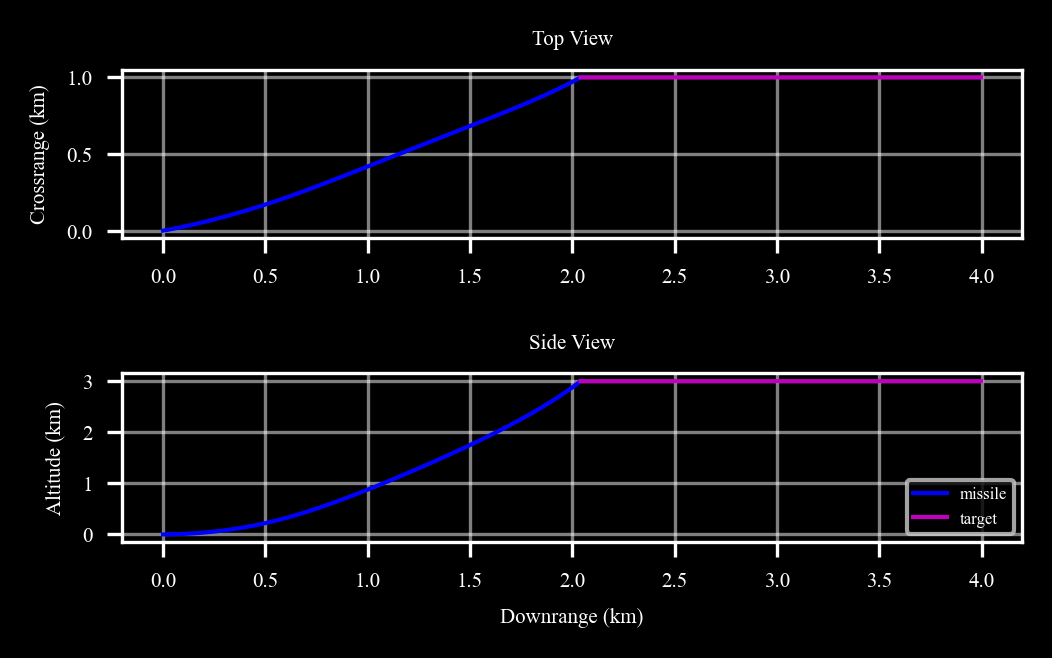

In [13]:
plt.switch_backend('inline')
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(missile.data('x', 1 / 1000)[1], missile.data('y', 1 / 1000)[1], 'b', linewidth = linewidth, label = 'missile')
ax1.plot(target.data('x', 1 / 1000)[1], target.data('y', 1 / 1000)[1], 'm', linewidth = linewidth, label = 'target')
c4d.plotdefaults(ax1, 'Top View', '', 'Crossrange (km)', fontsize = fontsize)

ax2.plot(missile.data('x', 1 / 1000)[1], -missile.data('z', 1 / 1000)[1], 'b', linewidth = linewidth, label = 'missile')
ax2.plot(target.data('x', 1 / 1000)[1], -target.data('z', 1 / 1000)[1], 'm', linewidth = linewidth, label = 'target')
c4d.plotdefaults(ax2, 'Side View', 'Downrange (km)', 'Altitude (km)', fontsize = fontsize)

plt.legend(fontsize = 4, facecolor = None, loc = 'lower right');

`Figure 3: Trajectories`  
The trajectory is shown from both a top view and a side view. 
The top view illustrates the missile’s crossrange motion relative to the target, while the side view displays the altitude change over the downrange distance. 
These plots visually confirm that the missile successfully intercepts the target with minimal miss distance, as the paths converge closely at the point of closest approach.

### Euler angles 

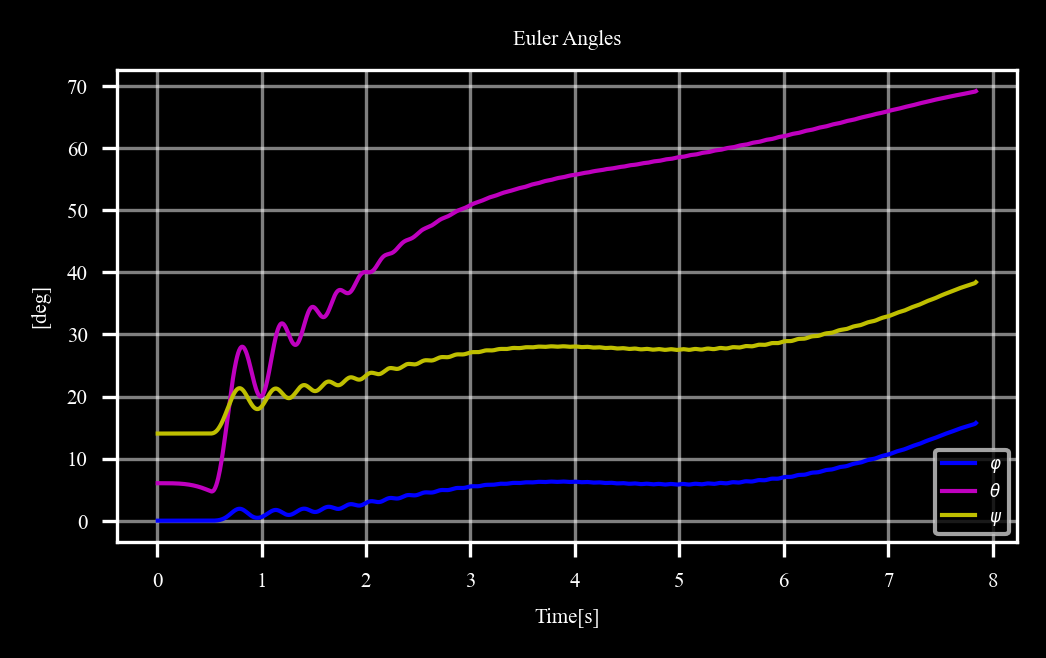

In [14]:
_, ax = plt.subplots()

ax.plot(*missile.data('phi', c4d.r2d), 'b', linewidth = linewidth, label = '$\\varphi$')
ax.plot(*missile.data('theta', c4d.r2d), 'm', linewidth = linewidth, label = '$\\theta$')
ax.plot(*missile.data('psi', c4d.r2d), 'y', linewidth = linewidth, label = '$\\psi$')
c4d.plotdefaults(ax, 'Euler Angles', 'Time[s]', '[deg]', fontsize = fontsize)

plt.legend(fontsize = 4, facecolor = None, loc = 'lower right');

`Figure 4: Euler Angles`  
This plot shows the evolution of the missile’s orientation angles — roll ($\varphi$), pitch ($\theta$), yaw ($\psi$) — throughout the flight. 
The variations in these angles reflect the missile’s rotational dynamics as it maneuvers to a collistion path with the target.



### Line-of-sight rates

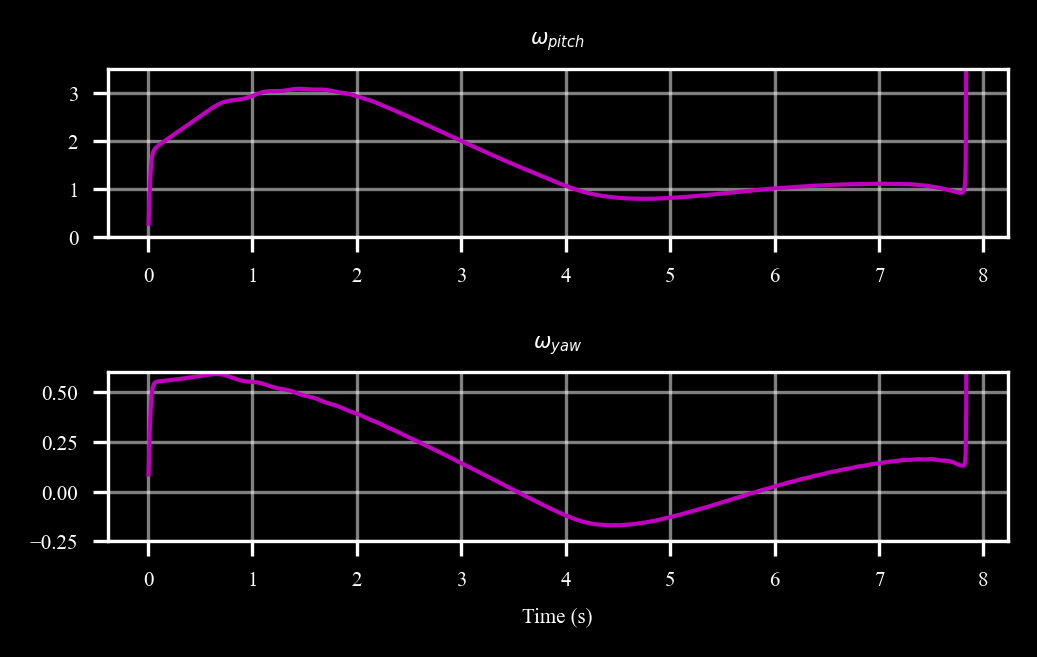

In [15]:
# omega los 
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(missile.data('t'), np.array(omegaf_data)[:, 0] * c4d.r2d, 'm', linewidth = linewidth)
ax2.plot(missile.data('t'), np.array(omegaf_data)[:, 1] * c4d.r2d, 'm', linewidth = linewidth)
ax1.set_ylim(0, 3.5)
ax2.set_ylim(-0.25, 0.6)
c4d.plotdefaults(ax1, '$\\omega_{pitch}$', fontsize = fontsize)
c4d.plotdefaults(ax2, '$\\omega_{yaw}$', 'Time (s)', fontsize = fontsize)

`Figure 5: Line-Of-Sight Rates`  
The line-of-sight (LOS) angular rates in pitch and yaw, denoted as $\omega_{pitch}$ and $\omega_{yaw}$, are shown as measured by the seeker. 
These rates are critical inputs to the proportional navigation guidance law. 
The decreasing trend in both angular rates toward zero suggests that the guidance system is effectively driving the LOS rotation to zero — indicating a successful intercept trajectory.



## 7. Provision for Monte Carlo Simulation

While this simulation demonstrates the development and testing of a guidance system, future work can explore the system’s sensitivity to internal modeling errors. 

In this implementation, the main loop was executed using a fixed sample of the seeker’s random variables, the time constants ($\tau_1$, $\tau_2$), which influence the accuracy of the LOS rate measurements. 

A Monte Carlo simulation can be conducted to evaluate how variability in these time constants affects system performance.

By introducing random variations within reasonable bounds for $\tau_1$ and $\tau_2$, one can assess the robustness of the guidance algorithm and its tolerance to modeling inaccuracies and hardware imperfections.


## 8. Summary

This 6DOF missile guidance simulation models the flight dynamics of a missile pursuing a non-maneuvering target, achieving a precise miss distance through the proportional navigation guidance algorithms. 
The simulation integrates translational and rotational equations of motion, accounts for aerodynamic forces, propulsion, and gravity, and employs a line-of-sight seeker to generate control commands. 

Trajectory plots and Euler angle visualizations reveal the missile’s dynamic behavior, offering insights into guidance system performance. 

Future enhancements could incorporate maneuvering targets or environmental effects to broaden the simulation’s applicability.


### References

1 Missile Flight Simulation Part One Surface-to-Air Missiles, MIL-HDBK-1211(MI) 17 July 1995. In: Military Handbook, 1995. 

